# Model 4: Text + Tabular Late Fusion
## Complex modality-specific models + SVM + XGBoost

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.svm import LinearSVC

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding,
    Dense, Dropout, BatchNormalization, Add,
    GlobalAveragePooling1D, GlobalMaxPooling1D,
    Concatenate, MultiHeadAttention, LayerNormalization,
    SpatialDropout1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import SimpleRNN # imported the SimpleRNN
import matplotlib.pyplot as plt # imported the plotting


In [3]:
df = pd.read_csv("/content/FoodFactsCleaned.csv")
df["nutriscore_letter"] = df["nutriscore_letter"].astype(int) - 1

In [4]:
TEXT_COLS = [
    "brand_cleaned",
    "allergens_cleaned",
    "ingredients_text_cleaned",
    "countries_cleaned",
    "additives_cleaned",
]

TABULAR_COLS = [
    'nova_group', 'fat_100g',
    'saturated_fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
    'proteins_100g', 'contains_palm_oil', 'vegetarian_status', 'vegan_status',
    'nutrient_level_fat', 'nutrient_level_saturated_fat',
    'nutrient_level_sugars', 'nutrient_level_salt', 'ecoscore_grade', 'ecoscore_score',
    'carbon_footprint_100g', 'additives_count', 'sugar_ratio',
    'energy_density', 'protein_ratio', 'macro_balance', 'healthy_score',
    'log_energy_kcal_100g', 'log_salt_100g'
]

TARGET_COL = "nutriscore_letter"
RANDOM_STATE = 42
TEST_SIZE = 0.2

MAX_WORDS = 30000
MAX_LEN   = 220

EPOCHS_TEXT = 20 # changed it from 12 to 20
EPOCHS_TAB  = 20 # changed it from 40 to 20
BATCH_SIZE_TEXT = 64
BATCH_SIZE_TAB  = 64 # changed it from 128 to 64

In [5]:
missing = [c for c in TEXT_COLS + TABULAR_COLS + [TARGET_COL] if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in df: {missing}")

for c in TEXT_COLS:
    df[c] = df[c].fillna("").astype(str)

df["text_concat"] = df[TEXT_COLS].agg(" ".join, axis=1)

X_text = df["text_concat"].values
X_tab  = df[TABULAR_COLS].values.astype(np.float32)
y_raw  = df[TARGET_COL].values

if y_raw.dtype == object or isinstance(y_raw[0], str):
    le = LabelEncoder()
    y = le.fit_transform(y_raw)
else:
    y = y_raw.astype(int)

num_classes = len(np.unique(y))
print("Classes:", num_classes)

Classes: 5


In [6]:
X_text_tr, X_text_te, X_tab_tr, X_tab_te, y_tr, y_te = train_test_split(
    X_text, X_tab, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", len(y_tr), "Test:", len(y_te))

Train: 2548 Test: 637


In [7]:
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_text_tr)

seq_tr = tokenizer.texts_to_sequences(X_text_tr)
seq_te = tokenizer.texts_to_sequences(X_text_te)

X_text_tr_pad = pad_sequences(seq_tr, maxlen=MAX_LEN, padding="post", truncating="post")
X_text_te_pad = pad_sequences(seq_te, maxlen=MAX_LEN, padding="post", truncating="post")

vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1)
print("Vocab size:", vocab_size)

scaler = StandardScaler()
X_tab_tr_sc = scaler.fit_transform(X_tab_tr).astype(np.float32)
X_tab_te_sc = scaler.transform(X_tab_te).astype(np.float32)

tab_dim = X_tab_tr_sc.shape[1]
print("Tab dim:", tab_dim)

Vocab size: 9953
Tab dim: 25


In [23]:
def build_text_model(vocab_size, max_len, num_classes, embed_dim=42):
    text_in = Input(shape=(max_len,), dtype=tf.int32, name="text_in")

    x = Embedding(vocab_size, embed_dim, name="txt_embed")(text_in)
    x = SpatialDropout1D(0.2)(x)

    avg_pool = GlobalAveragePooling1D(name="txt_gap")(x)
    max_pool = GlobalMaxPooling1D(name="txt_gmp")(x)
    x = Concatenate(name="txt_pool_concat")([avg_pool, max_pool])

    x = Dense(128, activation="relu")(x)
    x = Dropout(0.4)(x)

    x = Dense(64, activation="relu", name="txt_embed_dense")(x)
    x = Dropout(0.3)(x)

    out = Dense(num_classes, activation="softmax", name="txt_out")(x)

    model = Model(inputs=text_in, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

text_model = build_text_model(vocab_size, MAX_LEN, num_classes)
text_model.summary()

text_model.fit(
    X_text_tr_pad, y_tr,
    validation_split=0.2,
    epochs=EPOCHS_TEXT,
    batch_size=BATCH_SIZE_TEXT,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", patience=1, factor=0.5, min_lr=1e-6)
    ],
    verbose=1
)

text_extractor = Model(
    inputs=text_model.input,
    outputs=text_model.get_layer("txt_embed_dense").output
)

Z_txt_tr = text_extractor.predict(X_text_tr_pad, batch_size=256, verbose=0)
Z_txt_te = text_extractor.predict(X_text_te_pad, batch_size=256, verbose=0)

print("Text embeddings:", Z_txt_tr.shape, Z_txt_te.shape)
Model: "functional_38"

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_in             │ (None, 220)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_embed           │ (None, 220, 42)   │    418,026 │ text_in[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_2 │ (None, 220, 42)   │          0 │ txt_embed[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_gap             │ (None, 42)        │          0 │ spatial_dropout1… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_gmp             │ (None, 42)        │          0 │ spatial_dropout1… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_pool_concat     │ (None, 84)        │          0 │ txt_gap[0][0],    │
│ (Concatenate)       │                   │            │ txt_gmp[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     10,880 │ txt_pool_concat[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_embed_dense     │ (None, 64)        │      8,256 │ dropout_7[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ txt_embed_dense[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_out (Dense)     │ (None, 5)         │        325 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 437,487 (1.67 MB)

 Trainable params: 437,487 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3498 - loss: 1.5352 - val_accuracy: 0.3235 - val_loss: 1.3947 - learning_rate: 0.0010
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3958 - loss: 1.4022 - val_accuracy: 0.5647 - val_loss: 1.2566 - learning_rate: 0.0010
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5532 - loss: 1.2399 - val_accuracy: 0.5745 - val_loss: 1.0448 - learning_rate: 0.0010
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5878 - loss: 1.0653 - val_accuracy: 0.6098 - val_loss: 0.9612 - learning_rate: 0.0010
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5941 - loss: 1.0124 - val_accuracy: 0.6020 - val_loss: 0.9208 - learning_rate: 0.0010
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6481 - loss: 0.9363 - val_accuracy: 0.6176 - val_loss: 0.8776 - learning_rate: 0.0010
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6678 - loss: 0.8468 - val_acc

In [24]:
history = text_model.fit(X_text_tr_pad, y_tr, epochs=10, batch_size=BATCH_SIZE_TEXT, validation_data=(X_text_te_pad, y_te))

scores = text_model.evaluate(X_text_te_pad, y_te, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7673 - loss: 0.6384 - val_accuracy: 0.6452 - val_loss: 0.9123
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7352 - loss: 0.6353 - val_accuracy: 0.6484 - val_loss: 0.9092
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7682 - loss: 0.5968 - val_accuracy: 0.6515 - val_loss: 0.9179
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7792 - loss: 0.6058 - val_accuracy: 0.6515 - val_loss: 0.9219
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7786 - loss: 0.5744 - val_accuracy: 0.6593 - val_loss: 0.9180
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7802 - loss: 0.5650 - val_accuracy: 0.6625 - val_loss: 0.9254
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7993 - loss: 0.5356 - val_accuracy: 0.6672 - val_loss: 0.9202
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7943 - loss: 0.5501 - val_accuracy: 0.6609 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6574 - loss: 0.9859 
Test Accuracy: 65.62%
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 65.62%


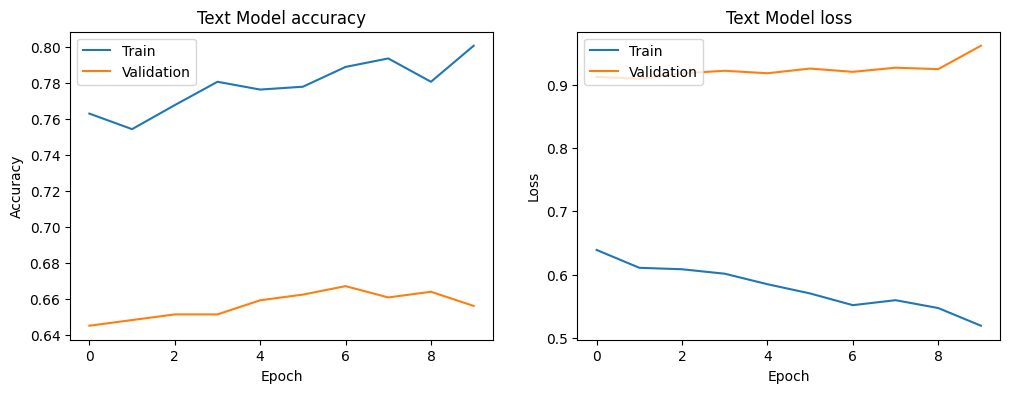

In [25]:
loss, accuracy = text_model.evaluate(X_text_te_pad, y_te)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred_probabilities = text_model.predict(X_text_te_pad)
y_pred = np.argmax(y_pred_probabilities, axis=1)

accuracy = accuracy_score(y_te, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Text Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Text Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [26]:


def build_tabular_model(tab_dim, num_classes):
    tab_in = Input(shape=(tab_dim,), dtype=tf.float32, name="tab_in")

    x = BatchNormalization(name="tab_bn0")(tab_in)
    x = Dense(512, activation="relu", name="tab_dense1")(x)
    x = BatchNormalization(name="tab_bn1")(x)
    x = Dropout(0.35, name="tab_drop1")(x)

    x = Dense(512, activation="relu", name="tab_proj")(x)

    x = Dense(256, activation="relu", name="tab_dense2")(x)
    x = Dropout(0.30, name="tab_drop2")(x)

    emb = Dense(256, activation="relu", name="tab_embedding")(x)
    emb = BatchNormalization(name="tab_emb_bn")(emb)
    emb = Dropout(0.30, name="tab_emb_drop")(emb)

    out = Dense(num_classes, activation="softmax")(emb)

    model = Model(inputs=tab_in, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

tab_model = build_tabular_model(tab_dim, num_classes)
tab_model.summary()

tab_model.fit(
    X_tab_tr_sc, y_tr,
    validation_split=0.4,
    epochs=EPOCHS_TAB,
    batch_size=BATCH_SIZE_TAB,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, min_lr=1e-6)
    ],
    verbose=1
)

tab_extractor = Model(
    inputs=tab_model.input,
    outputs=tab_model.get_layer("tab_embedding").output
)

Z_tab_tr = tab_extractor.predict(X_tab_tr_sc, batch_size=256, verbose=0)
Z_tab_te = tab_extractor.predict(X_tab_te_sc, batch_size=256, verbose=0)

print("Tabular embeddings:", Z_tab_tr.shape, Z_tab_te.shape)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tab_in (InputLayer)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tab_bn0 (BatchNormalization)    │ (None, 25)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tab_dense1 (Dense)              │ (None, 512)            │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tab_bn1 (BatchNormalization)    │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tab_drop1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tab_proj (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tab_dense2 (Dense)              │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tab_drop2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tab_embedding (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tab_emb_bn (BatchNormalization) │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tab_emb_drop (Dropout)          │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 477,545 (1.82 MB)

 Trainable params: 475,959 (1.82 MB)

 Non-trainable params: 1,586 (6.20 KB)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.5580 - loss: 1.3412 - val_accuracy: 0.7843 - val_loss: 0.8932 - learning_rate: 0.0010
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7563 - loss: 0.6494 - val_accuracy: 0.7971 - val_loss: 0.7144 - learning_rate: 0.0010
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7812 - loss: 0.6161 - val_accuracy: 0.7902 - val_loss: 0.6792 - learning_rate: 0.0010
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7967 - loss: 0.5170 - val_accuracy: 0.7824 - val_loss: 0.6229 - learning_rate: 0.0010
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8131 - loss: 0.5132 - val_accuracy: 0.7382 - val_loss: 0.7032 - learning_rate: 0.0010
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8384 - loss: 0.4393 - val_accuracy: 0.7686 - val_loss: 0.5685 - learning_rate: 0.0010
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8449 - loss: 0.4477 - val_acc

In [27]:
history = tab_model.fit(X_tab_tr_sc, y_tr, epochs=10, batch_size=BATCH_SIZE_TEXT, validation_data=(X_tab_te_sc, y_te))

scores = tab_model.evaluate(X_tab_te_sc, y_te, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8667 - loss: 0.3523 - val_accuracy: 0.8509 - val_loss: 0.4274
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8633 - loss: 0.3564 - val_accuracy: 0.8509 - val_loss: 0.4266
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8658 - loss: 0.3356 - val_accuracy: 0.8524 - val_loss: 0.4344
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8788 - loss: 0.3159 - val_accuracy: 0.8524 - val_loss: 0.4233
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8923 - loss: 0.3001 - val_accuracy: 0.8634 - val_loss: 0.4142
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8903 - loss: 0.2856 - val_accuracy: 0.8571 - val_loss: 0.4227
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8734 - loss: 0.3482 - val_accuracy: 0.8650 - val_loss: 0.4236
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8838 - loss: 0.3088 - val_accuracy: 0.8571 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8554 - loss: 0.4686
Test Accuracy: 87.28%
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy: 87.28%


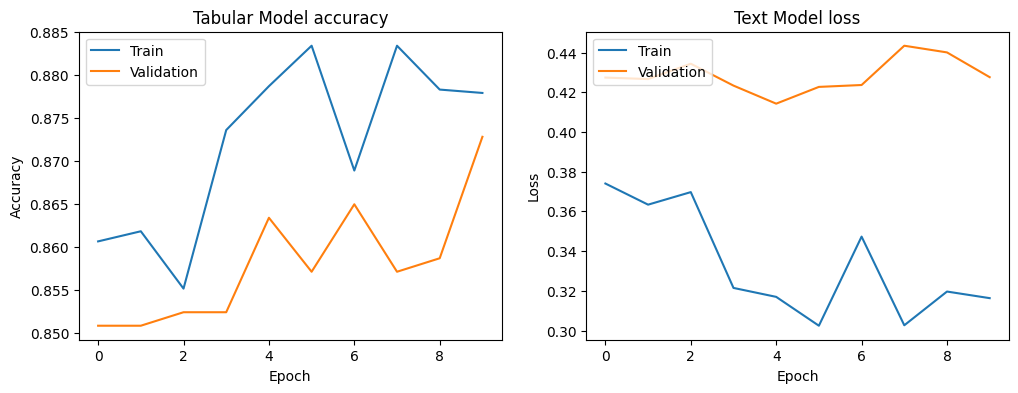

In [28]:
loss, accuracy = tab_model.evaluate(X_tab_te_sc, y_te)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred_probabilities = tab_model.predict(X_tab_te_sc)
y_pred = np.argmax(y_pred_probabilities, axis=1)

accuracy = accuracy_score(y_te, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Tabular Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Text Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [29]:
X_fused_tr = np.hstack([Z_txt_tr, Z_tab_tr])
X_fused_te = np.hstack([Z_txt_te, Z_tab_te])

print("Fused feature shape:", X_fused_tr.shape, X_fused_te.shape)

Fused feature shape: (2548, 320) (637, 320)


In [30]:
X_fused_tr = np.nan_to_num(X_fused_tr, nan=0.0, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)
X_fused_te = np.nan_to_num(X_fused_te, nan=0.0, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)

svm = LinearSVC(C=1.0, class_weight="balanced", random_state=RANDOM_STATE)
svm.fit(X_fused_tr, y_tr)
svm_pred = svm.predict(X_fused_te)
svm_train_pred = svm.predict(X_fused_tr)# added that line

train_acc = accuracy_score(y_tr, svm_train_pred)# added that line
test_acc = accuracy_score(y_te, svm_pred)# added that line

print("\n=== Final: Linear SVM on fused embeddings (Text+Tab) ===")
print("Accuracy:", accuracy_score(y_te, svm_pred))
print("Macro-F1:", f1_score(y_te, svm_pred, average="macro"))
print(classification_report(y_te, svm_pred))

print("\nFull Classification Report (Test):")# added that line
print(classification_report(y_te, svm_pred))# added that line


=== Final: Linear SVM on fused embeddings (Text+Tab) ===
Accuracy: 0.8461538461538461
Macro-F1: 0.762401906430175
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       176
           1       0.50      0.50      0.50        20
           2       0.70      0.72      0.71        69
           3       0.76      0.77      0.76       141
           4       0.90      0.90      0.90       231

    accuracy                           0.85       637
   macro avg       0.76      0.76      0.76       637
weighted avg       0.85      0.85      0.85       637


Full Classification Report (Test):
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       176
           1       0.50      0.50      0.50        20
           2       0.70      0.72      0.71        69
           3       0.76      0.77      0.76       141
           4       0.90      0.90      0.90       231

    accuracy                      

In [31]:
xgb = XGBClassifier(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="multi:softmax" if num_classes > 2 else "binary:logistic",
    num_class=num_classes if num_classes > 2 else None,
    eval_metric="mlogloss" if num_classes > 2 else "logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb.fit(X_fused_tr, y_tr)
xgb_pred = xgb.predict(X_fused_te)

print("\n=== Final: XGBoost on fused embeddings (Text+Tab) ===")
print("Accuracy:", accuracy_score(y_te, xgb_pred))
print("Macro-F1:", f1_score(y_te, xgb_pred, average="macro"))
print(classification_report(y_te, xgb_pred))


=== Final: XGBoost on fused embeddings (Text+Tab) ===
Accuracy: 0.8665620094191523
Macro-F1: 0.7908313365505902
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       176
           1       0.58      0.55      0.56        20
           2       0.74      0.74      0.74        69
           3       0.80      0.77      0.78       141
           4       0.90      0.92      0.91       231

    accuracy                           0.87       637
   macro avg       0.79      0.79      0.79       637
weighted avg       0.87      0.87      0.87       637



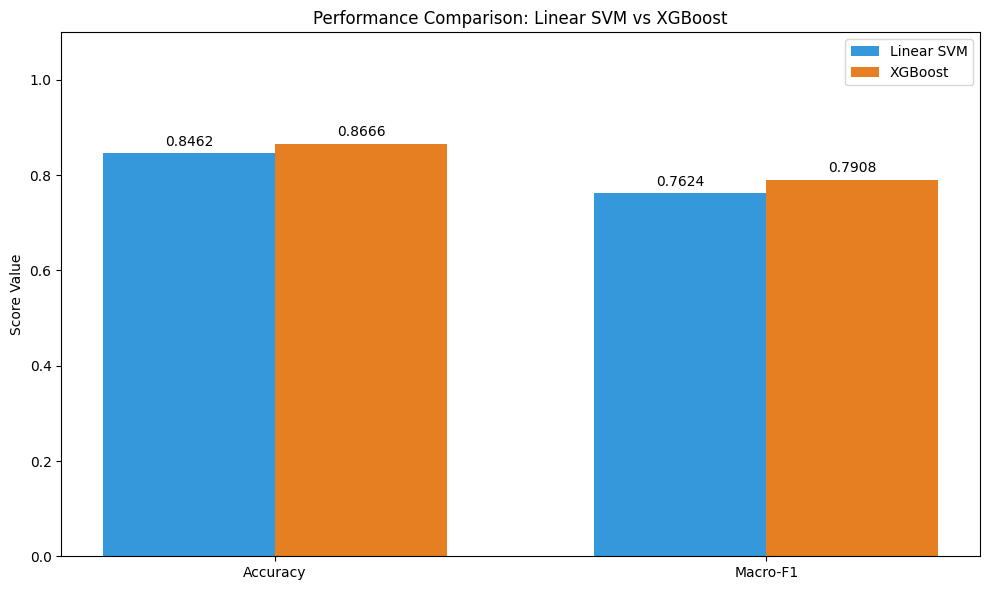

In [32]:
svm_acc = accuracy_score(y_te, svm_pred)
svm_f1 = f1_score(y_te, svm_pred, average="macro")

xgb_acc = accuracy_score(y_te, xgb_pred)
xgb_f1 = f1_score(y_te, xgb_pred, average="macro")

labels = ['Accuracy', 'Macro-F1']
svm_scores = [svm_acc, svm_f1]
xgb_scores = [xgb_acc, xgb_f1]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, svm_scores, width, label='Linear SVM', color='#3498db')
rects2 = ax.bar(x + width/2, xgb_scores, width, label='XGBoost', color='#e67e22')

ax.set_ylabel('Score Value')
ax.set_title('Performance Comparison: Linear SVM vs XGBoost')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.1)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('model_comparison.png')